In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
import warnings
# Set action = "ignore" to ignore warnings
warnings.filterwarnings(action= 'ignore')
# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import tools 
from model_dc_multidim import model_dc_multidim
import time

In [2]:
t0 = time.time()  # set the starting time
model = model_dc_multidim()
model.setup()
model.create_grids()
model.solve()
t1 = time.time() # set the ending time
print(f'time: {t1-t0:.8} seconds') # print the total time

Evaluating period: 68
Evaluating period: 67
Evaluating period: 66
Evaluating period: 65
Evaluating period: 64
Evaluating period: 63
Evaluating period: 62
Evaluating period: 61
Evaluating period: 60
Evaluating period: 59
Evaluating period: 58
Evaluating period: 57
Evaluating period: 56
Evaluating period: 55
Evaluating period: 54
Evaluating period: 53
Evaluating period: 52
Evaluating period: 51
Evaluating period: 50
Evaluating period: 49
Evaluating period: 48
Evaluating period: 47
Evaluating period: 46
Evaluating period: 45
Evaluating period: 44
Evaluating period: 43
Evaluating period: 42
Evaluating period: 41
Evaluating period: 40
Evaluating period: 39
Evaluating period: 38
Evaluating period: 37
Evaluating period: 36
Evaluating period: 35
Evaluating period: 34
Evaluating period: 33
Evaluating period: 32
Evaluating period: 31
Evaluating period: 30
Evaluating period: 29
Evaluating period: 28
Evaluating period: 27
Evaluating period: 26
Evaluating period: 25
Evaluating period: 24
Evaluating

In [3]:
model.par.T

70

In [4]:
model.create_hour_bunches()

array([[   0,    0],
       [ 550, 2000],
       [   0, 2000],
       [1000, 2500],
       [ 550, 2500],
       [ 550, 3000],
       [   0, 3000]])

In [5]:
seed = np.random.seed(999)

def human_capital(t, health):
    # see plot, increases with age up untill a certain point
    
    inc0=0.75
    inc1=0.04
    inc2=0.0003
    
    age = t + 19
    return( (2*health) * np.exp(inc0 + inc1*age - inc2*age**2))

def simulate (model):
    par = model.par
    
    sol = model.sol
    sim = model.sim

    
    # Initialize
    shape = (par.simT, par.simN)
    sim.m = np.nan +np.zeros(shape)
    sim.c = np.nan +np.zeros(shape)
    sim.a = np.nan +np.zeros(shape)
    sim.h = np.nan +np.zeros(shape)
    
    sim.Th = np.nan +np.zeros(shape)
    sim.Tw = np.nan +np.zeros(shape)
    sim.income = np.nan +np.zeros(shape)
    sim.wage = np.nan +np.zeros(shape)
    
    sim.y = np.nan +np.zeros(shape)

    par.Nshocks = par.xi.size * par.Na
    # Shocks
    
    # 0.05
    par.xi,par.xi_w = tools.GaussHermite_lognorm(0.05,par.Nxi)
    shock = np.random.choice(par.xi, (par.T,par.simN),replace=True,p=par.xi_w) #draw values between 0 and Nshocks-1, with probability w
    
    sim.xi = shock

    # Initial values
    sim.m[0,:] = 10
    sim.h[0,:] = np.random.uniform(1, 1, par.simN) 

    # Simulation 
    for t in range(par.simT):
        V = np.zeros( (model.par.NT, model.par.simN) )
        C = np.zeros( (model.par.NT, model.par.simN) )
        for i, T_i in enumerate(model.par.T_boundles): # possible hour choices
            C[i, :] =tools.interp_2d_vec(par.grid_m, par.grid_h, sol.c[t, i], sim.m[t, :], sim.h[t, :])
            V[i, :] = tools.interp_2d_vec(par.grid_m , par.grid_h, sol.v[t, i ], sim.m[t, :], sim.h[t, :]) # value for every choice
        
        h_i = V.argmax(0) # index of best choice
        sim.Th[t, :] = model.par.T_boundles[h_i][:, 0]
        sim.Tw[t, :] = model.par.T_boundles[h_i][:, 1]
        Cs = C[:, h_i][0, :] # magic to get all the best choices
        
        sim.c[t, :] = Cs
        sim.a[t,:] = sim.m[t,:] - sim.c[t,:]
        if t< par.simT-1:
            
            sim.h[t+1,:] = (1 - par.gamma + par.kappa * (sim.Th[t, :]) / (1000) -0.01 * (t > 40) ) * sim.h[t, :]
            wage = human_capital(t, sim.h[t,:]) * sim.xi[t, :] # next period wage w. health effect on wage 
            sim.wage[t, :] = wage
            sim.income[t,:] = wage * (sim.Tw[t, :]) / (3000)
            
            #print()
            m_plus = par.R * sim.a[t, :] + wage * (sim.Tw[t, :]) / (3000)
            
            sim.m[t+1,:] = m_plus
simulate(model)

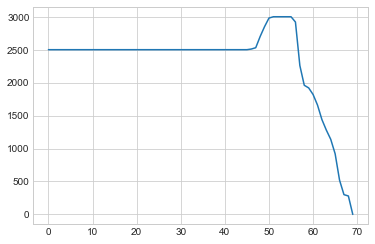

In [15]:
def plot_simulation(range_):
    '''
    range_ (int): number of simaultaions (max 10)
    '''
    hs = []
    tim = [range(range_)]
    for i in range(range_):
        h = model.sim.Tw[i, :]
        #print(h)
        h = np.average(h)
        hs.append(h)
    plt.plot(hs)
    plt.show()
plot_simulation(70)

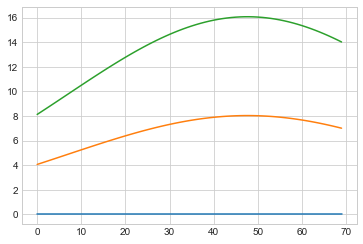

In [7]:
def human_capital(t, h):
    inc0=0.75
    inc1=0.04
    inc2=0.0003
    
    age = t + 19
    return( (2*h) * np.exp(inc0 + inc1*age - inc2*age**2))

for health in [0, 0.5, 1]:
    hs = []
    for i in range(70):
        hs.append( human_capital(i, health) )
    plt.plot(hs)

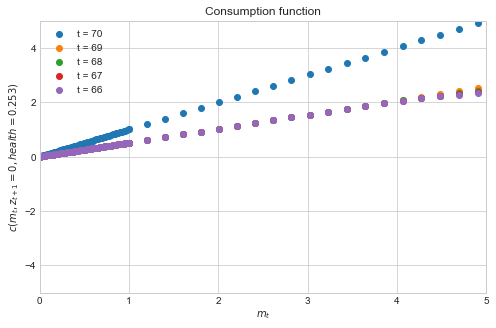

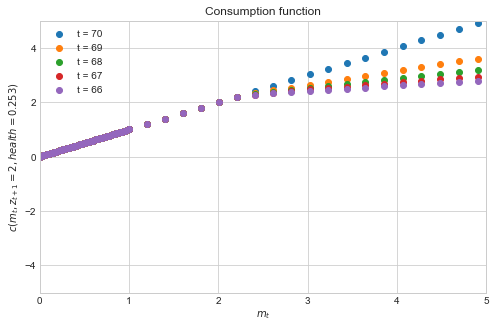

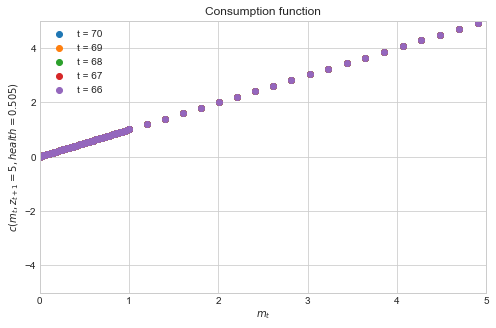

In [8]:
###### Figure
def figure_multi_dim(par,sol,T,i_h):
    
    p = par.grid_h[i_h]
    ts = [par.T, par.T-1, par.T-2, par.T-3, par.T-4]
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    
    for i in ts:
        ax.scatter(par.grid_m,sol.c[i-1,T,:,i_h], label=f't = {i}')
    ax.set_xlabel(f"$m_t$")
    ax.set_ylabel(f"$c(m_t,z_{{t+1}} = {T}, health = {p:.3})$")
    ax.set_xlim([0, 5])
    ax.set_ylim([-5,5])
    ax.set_title(f'Consumption function')
    plt.legend()
    plt.show()

figure_multi_dim(model.par,model.sol,0,25)
figure_multi_dim(model.par,model.sol,2,25)
figure_multi_dim(model.par,model.sol,5,50)